# Image Recognition
In this, we will train a convolutional neural network model to identify the handwritten digits (MNIST dataset) using PyTorch.

In [1]:
# Import modules
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
# Define device for torch as GPU to utilize cuda tensor types instead of cpu tensor types
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Apply transformations, first resize numpy array to 28x28, convert numpy array to tensor, last normalize using mean and std vectors
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
# Download and Load MNIST training dataset and apply image transformations to transform from numpy array to Tensor
training_dataset = datasets.MNIST(root='./data_digits', train=True, download=True, transform=transform)
# Validation Dataset
validation_dataset = datasets.MNIST(root='./data_digits', train=False, download=True, transform=transform)
# Load a batch of 100 shuffled images from dataset to reduce the load on GPU
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
# Validation Dataloader
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [4]:
# Convert image from tensor to numpy array for plotting
def im_convert(tensor):
    # Copy tensor and convert to numpy
    image = tensor.clone().detach().numpy()
    # Change 1x28x28 dimensions to 28x28x1
    image = image.transpose(1, 2, 0)
    # De-normalize the image using the same mean and std
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    # To make sure the range of image pixels is between 0 and 1
    image = image.clip(0, 1)
    return image

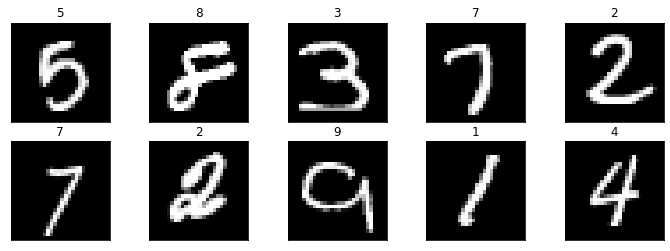

In [5]:
# Iterate through each batch of images
dataiter = iter(training_loader)
# Get first batch of images and labels
images, labels = next(dataiter)
# Create a figure to plot
fig = plt.figure(figsize=(12, 4))
# Plot the first 20 images in 2 row
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

In [6]:
# Define the Classifier using convolutional layers
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Define first convolutional layer with 1 input, 20 output, 5 kernel size, 1 stride length
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        # Define 2nd convolutional layer with 20 input, 50 output, 5 kernel size, 1 stride length
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        # Define 1st fully connected layer
        self.fc1 = nn.Linear(4*4*50, 500)
        # Define dropout function to reduce the overfitting
        self.dropout1 = nn.Dropout(0.5)
        # Define 2nd fully connected layer
        self.fc2 = nn.Linear(500, 10)

    # Define the forward function using ReLu activation function
    def forward(self, x):
        # First input will be passed to first convolutional layer
        pred = F.relu(self.conv1(x))
        # Next the output from 1st conv layer will be passed to 1st pooling layer with 2x2 pooling kernel
        pred = F.max_pool2d(pred, 2, 2)

        # Next the output from 1st pooling layer will be passed to 2nd convolutional layer
        pred = F.relu(self.conv2(pred))
        # Next the output from 2nd conv layer will be passed to 2nd pooling layer with 2x2 pooling kernel
        pred = F.max_pool2d(pred, 2, 2)

        # Flatten the output from 2nd pooling layer
        pred = pred.view(-1, 4*4*50)
        # Pass the flattened output to 1st fully connected layer
        pred = F.relu(self.fc1(pred))
        # Use the Dropout function
        pred = self.dropout1(pred)
        # Pass the output from 1st fc layer to 2nd fc layer with no activation function
        pred = self.fc2(pred)
        return pred

In [7]:
# Initialize the Classifier
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [9]:
epochs = 15
train_losses = []
train_predicts = []
val_losses = []
val_predicts = []
for e in range(epochs):
    train_loss = 0.0
    train_predict = 0.0
    val_loss = 0.0
    val_predict = 0.0
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get the max score for each image in the batch
        _, preds = torch.max(outputs, 1)
        # Compare the max score with actual label value for each image in the batch
        train_predict += torch.sum(preds == labels.data)
        # Append loss for each batch
        train_loss += loss.item()
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model.forward(val_inputs)
                v_loss = criterion(val_outputs, val_labels)

                # Get the max score for each image in the batch
                _, val_preds = torch.max(val_outputs, 1)
                # Compare the max score with actual label value for each image in the batch
                val_predict += torch.sum(val_preds == val_labels.data)
                # Append loss for each batch
                val_loss += v_loss.item()

        # Calculate average loss for batch
        train_epoch_loss = train_loss/len(training_loader.dataset)
        # Calculate average accuracy for batch
        train_epoch_acc = train_predict.float()/len(training_dataset)
        train_losses.append(train_epoch_loss)
        train_predicts.append(train_epoch_acc)

         # Calculate average loss for batch
        val_epoch_loss = val_loss/len(validation_loader.dataset)
        # Calculate average accuracy for batch
        val_epoch_acc = val_predict.float()/len(validation_dataset)
        val_losses.append(val_epoch_loss)
        val_predicts.append(val_epoch_acc)
        print('epoch:', (e+1))
        print('training loss {:.4f}, acc {:.4f}'.format(train_epoch_loss, train_epoch_acc.item()))
        print('validation loss {:.4f}, acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch: 1
training loss 0.0056, acc 0.8466
validation loss 0.0017, acc 0.9488
epoch: 2
training loss 0.0014, acc 0.9579
validation loss 0.0010, acc 0.9682
epoch: 3
training loss 0.0010, acc 0.9714
validation loss 0.0007, acc 0.9796
epoch: 4
training loss 0.0008, acc 0.9772
validation loss 0.0006, acc 0.9813
epoch: 5
training loss 0.0006, acc 0.9810
validation loss 0.0006, acc 0.9822
epoch: 6
training loss 0.0005, acc 0.9833
validation loss 0.0005, acc 0.9844
epoch: 7
training loss 0.0005, acc 0.9846
validation loss 0.0005, acc 0.9862
epoch: 8
training loss 0.0004, acc 0.9862
validation loss 0.0004, acc 0.9875
epoch: 9
training loss 0.0004, acc 0.9877
validation loss 0.0003, acc 0.9888
epoch: 10
training loss 0.0004, acc 0.9890
validation loss 0.0004, acc 0.9885
epoch: 11
training loss 0.0003, acc 0.9902
validation loss 0.0004, acc 0.9886
epoch: 12
training loss 0.0003, acc 0.9905
validation loss 0.0003, acc 0.9907
epoch: 13
training loss 0.0003, acc 0.9918
validation loss 0.0003, acc 0.

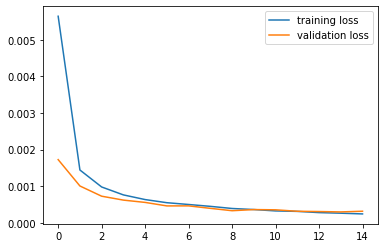

In [10]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

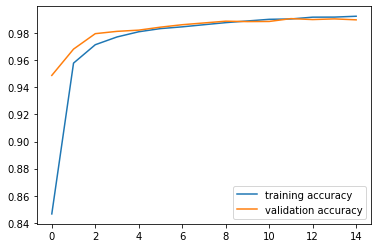

In [11]:
plt.plot(train_predicts, label='training accuracy')
plt.plot(val_predicts, label='validation accuracy')
plt.legend()

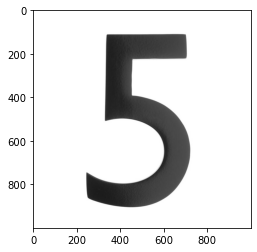

In [12]:
import requests
import PIL
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

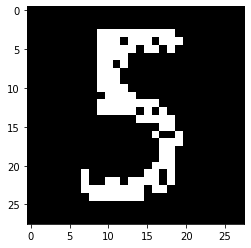

In [13]:
# Invert the image to match with MNIST dataset (black background, white foreground)
img = PIL.ImageOps.invert(img)
# Convert image from RGB to gray
img = img.convert('1')
# Transform image: resize 28x28, convert to tensor and normalize
img = transform(img)
plt.imshow(im_convert(img))

In [14]:
# Convert the image to match with model input
inp = img.to(device)
inp = inp[0].unsqueeze(0).unsqueeze(0)
# Predict the digit in the image
output = model.forward(inp)
# Find the index of the max score
val, idx = torch.max(output, 1)
print(val.item(), idx.item())

18.732955932617188 5


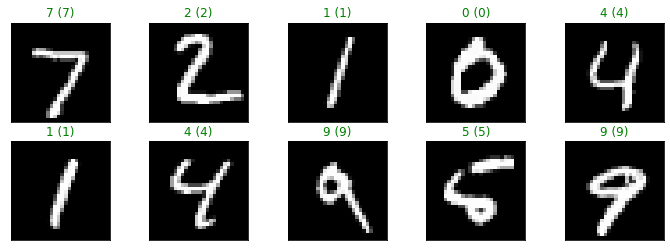

In [15]:
# Iterate through each batch of images
dataiter = iter(validation_loader)
# Get first batch of images and labels
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
output = model.forward(images)
vals, preds = torch.max(output, 1)
# Create a figure to plot
fig = plt.figure(figsize=(12, 4))
# Plot the first 20 images in 2 row
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    # convert image tensor to cpu tensor for plotting
    plt.imshow(im_convert(images[idx].cpu()))
    ax.set_title('{} ({})'.format(str(preds[idx].item()), str(labels[idx].item())), color='green' if (preds[idx] == labels[idx]) else 'red')

In [20]:
# Check Graphics Card details in MACPro
!system_profiler SPDisplaysDataType

Graphics/Displays:

    Intel HD Graphics 4000:

      Chipset Model: Intel HD Graphics 4000
      Type: GPU
      Bus: Built-In
      VRAM (Dynamic, Max): 1536 MB
      Vendor: Intel
      Device ID: 0x0166
      Revision ID: 0x0009
      Metal: Supported, feature set macOS GPUFamily1 v4
      Displays:
        ED273UR:
          Resolution: 1920 x 1080 (1080p FHD - Full High Definition)
          UI Looks like: 1920 x 1080 @ 60 Hz
          Framebuffer Depth: 24-Bit Color (ARGB8888)
          Main Display: Yes
          Mirror: Off
          Online: Yes
          Rotation: Supported
          Automatically Adjust Brightness: No

